# Reinforcement Learning for Goal-Directed Molecular Generation

## Fine-Tuning a Conditional Generative Model with Policy Gradients

---

### Notebook Overview

This notebook demonstrates **Reinforcement Learning (RL)** for optimizing molecular generation toward specific LogP targets using **policy gradient methods (REINFORCE algorithm)**.

**Three-Stage Pipeline:**
1. **Pre-training:** Supervised learning on real molecules (conditional GPT)
2. **RL Fine-tuning:** Policy gradients to optimize for target LogP
3. **Evaluation:** Compare before vs after RL performance

**Key RL Concepts:**
- **Agent:** Conditional GPT generator
- **Action:** Generate next SMILES token
- **Reward:** Gaussian function of LogP error
- **Policy Gradient:** REINFORCE algorithm

---

## 1. Import Required Libraries

Setting up the environment for RL-based molecular generation.

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, RDConfig
from rdkit import RDLogger

import requests
from io import StringIO
import re
import math
import warnings
from tqdm import tqdm

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using device: cuda


---

## 2. Data Loading and Preprocessing

### 2.1 Load ZINC Database

We load a subset of the ZINC database containing drug-like molecules with calculated properties.

**Dataset properties:**
- SMILES: Molecular structure notation
- LogP: Lipophilicity (octanol-water partition coefficient)
- QED: Quantitative Estimate of Drug-likeness
- SAS: Synthetic Accessibility Score

**Data preparation:**
- Remove invalid SMILES (molecules RDKit cannot parse)
- Sample 10,000 molecules for faster training
- This subset is sufficient for demonstration

### 2.2 Build Tokenizer

We create a regex-based tokenizer for SMILES strings.

**Tokenization approach:**
- Regex pattern captures chemical tokens:
  - Atoms: C, N, O, Br, Cl, etc.
  - Bonds: =, #, -, /, \
  - Rings: digits 0-9
  - Branches: (, )
  - Charges: [NH+], [O-], etc.

**Special tokens:**
- `<pad>`: Padding for variable lengths
- `<start>`: Start of sequence
- `<end>`: End of sequence

**Encoding/Decoding:**
- `encode()`: SMILES → list of token indices
- `decode()`: list of indices → SMILES

**Example:**
```
SMILES: CCO
Tokens: ['C', 'C', 'O']
Encoded: [1, 12, 12, 25, 2]  # <start>, C, C, O, <end>
```

Loaded 10000 molecules.
Vocab Size: 49


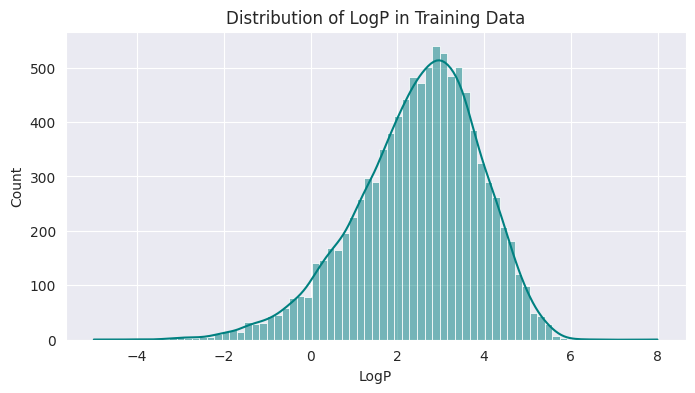

In [2]:
# --- 1. Data Loading & Preprocessing ---

def load_dataset():
    print("Downloading dataset...")
    # Using a subset of ZINC or ESOL for demonstration speed
    url = "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"

    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    df = df[['smiles', 'logP', 'qed', 'SAS']]
    df.columns = ['SMILES', 'LogP', 'QED', 'SAS']

    # Quick valid check
    df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)
    df = df.dropna(subset=['mol'])
    df = df.drop(columns=['mol'])

    # Taking a subset for faster demonstration training
    df = df.sample(n=10000, random_state=SEED).reset_index(drop=True)
    print(f"Loaded {len(df)} molecules.")
    return df

df = load_dataset()

# --- 2. Tokenizer (Regex Based) ---
class Tokenizer:
    def __init__(self, smiles_list):
        # Regex pattern for chemical tokens (from your conditional_gpt notebook)
        self.pattern = re.compile(r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])")

        tokens = set()
        for s in smiles_list:
            tokens.update(self.pattern.findall(s))

        self.vocab = sorted(list(tokens))
        self.vocab = ['<pad>', '<start>', '<end>'] + self.vocab

        self.stoi = {t:i for i,t in enumerate(self.vocab)}
        self.itos = {i:t for i,t in enumerate(self.vocab)}

    def encode(self, smile, max_len=None):
        tokens = self.pattern.findall(smile)
        ids = [self.stoi['<start>']] + [self.stoi.get(t, self.stoi['<pad>']) for t in tokens] + [self.stoi['<end>']]

        if max_len is not None:
            if len(ids) < max_len:
                ids += [self.stoi['<pad>']] * (max_len - len(ids))
            else:
                ids = ids[:max_len]
        return ids

    def decode(self, ids):
        tokens = []
        for i in ids:
            token = self.itos.get(i, '')
            if token == '<end>': break
            if token not in ['<pad>', '<start>']:
                tokens.append(token)
        return "".join(tokens)

    @property
    def vocab_size(self):
        return len(self.vocab)

# Initialize Tokenizer
tokenizer = Tokenizer(df['SMILES'])
MAX_LEN = 64  # Fixed sequence length for simplicity
print(f"Vocab Size: {tokenizer.vocab_size}")

# Visualize Data Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['LogP'], kde=True, color='teal')
plt.title("Distribution of LogP in Training Data")
plt.show()

### 2.3 Create PyTorch Dataset

We define a custom Dataset class for conditional molecular generation.

**Dataset structure:**

Each sample returns:
- `x`: Input sequence (all tokens except last)
- `y`: Target sequence (all tokens except first) - teacher forcing
- `prop`: Target LogP value (condition)

**Teacher forcing:**
```
Full sequence: [<start>, C, C, O, <end>]
Input (x):     [<start>, C, C, O]
Target (y):    [C, C, O, <end>]

Model learns: Given <start>, predict C
             Given C, predict C
             Given C C, predict O
             Given C C O, predict <end>
```

**Why condition on LogP?**
- Model learns correlation between LogP and structure
- At generation time, we can specify desired LogP
- Enables goal-directed generation

In [3]:
class MoleculeDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smiles = row['SMILES']
        logp = row['LogP']

        # Encode
        ids = self.tokenizer.encode(smiles, self.max_len)

        return {
            'x': torch.tensor(ids[:-1], dtype=torch.long),      # Input
            'y': torch.tensor(ids[1:], dtype=torch.long),       # Target (Next Token)
            'prop': torch.tensor([logp], dtype=torch.float32)   # Property (Condition)
        }

train_dataset = MoleculeDataset(df, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

---

## 3. Train LogP Predictor (Optional)

### 3.1 Predictor Architecture

We train an LSTM to predict LogP from SMILES, demonstrating that neural networks can learn molecular properties.

**Model structure:**
```
SMILES tokens → Embedding → LSTM → Final Hidden State → LogP
```

**Architecture:**
- Embedding layer: Token indices → dense vectors
- LSTM: Process sequence, capture dependencies
- Linear layer: Hidden state → LogP prediction

**Training:**
- Loss: MSE between predicted and actual LogP
- 5 epochs for quick demonstration
- Expected loss: ~0.3-0.5

**Important Note:**

While this predictor demonstrates property prediction capability, **we use RDKit's LogP calculation directly in the RL loop** for:
- Accuracy: Deterministic, validated calculations
- Speed: Fast enough for real-time evaluation
- Simplicity: No prediction uncertainty in rewards

In scenarios with expensive property calculations (e.g., DFT simulations), a trained predictor becomes essential.

In [4]:
class LogPPredictor(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [Batch, SeqLen]
        emb = self.embedding(x)
        _, (h_n, _) = self.rnn(emb) # h_n: [1, Batch, Hidden]
        return self.fc(h_n.squeeze(0))

print("Training Predictor...")
predictor = LogPPredictor(tokenizer.vocab_size).to(device)
pred_optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-3)
pred_criterion = nn.MSELoss()

# Quick Train Loop for Predictor
for epoch in range(5):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Predictor Epoch {epoch+1}", leave=False):
        x = batch['x'].to(device) # We use the input sequence as the molecule representation
        target_logp = batch['prop'].to(device)

        pred_optimizer.zero_grad()
        preds = predictor(x)
        loss = pred_criterion(preds, target_logp)
        loss.backward()
        pred_optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

print("Predictor Trained.")

Training Predictor...


Epoch 1 Loss: 2.2247


Epoch 2 Loss: 0.8136


Epoch 3 Loss: 0.3809


Epoch 4 Loss: 0.2616


Epoch 5 Loss: 0.1815
Predictor Trained.


---

## 4. Define Conditional GPT Generator

### 4.1 Model Architecture

We implement a conditional GPT (Generative Pre-trained Transformer) for molecule generation.

**Why GPT for Molecules?**
- Autoregressive: Generates tokens sequentially
- Causal attention: Attends only to previous tokens
- Scalable: Handles variable-length sequences
- Powerful: State-of-the-art sequence generation

**Architecture Components:**

**1. GPTConfig:**
- Hyperparameters for model
- n_layer: Number of transformer blocks
- n_head: Multi-head attention heads
- n_embd: Embedding dimension
- block_size: Maximum sequence length

**2. CausalSelfAttention:**
- Multi-head self-attention mechanism
- Causal mask: Prevents attending to future tokens
- Scaled dot-product attention
```
Attention(Q,K,V) = softmax(QK^T / √d_k) V
```

**3. Block (Transformer Layer):**
- Layer normalization
- Self-attention
- Feed-forward network (MLP)
- Residual connections
```
x = x + Attention(LayerNorm(x))
x = x + MLP(LayerNorm(x))
```

**4. ConditionalGPT:**
- Token embedding layer
- **Property embedding: LogP → vector**
- Position embedding
- Stack of transformer blocks
- Output head: Logits over vocabulary

**Conditioning Mechanism:**

The property value is embedded and added to token embeddings:
```python
token_emb = embedding(tokens)        # [B, T, n_embd]
prop_emb = prop_embedding(logp)      # [B, 1, n_embd]
combined = token_emb + prop_emb      # Broadcast property to all positions
```

**Why this works:**
- Property information available at every position
- Model learns correlation: structure ↔ property
- At generation, specify target LogP → model generates appropriate molecules

**Generation Process:**

```
Input: <start> + Target LogP (e.g., 3.5)
  ↓
Model predicts next token probabilities
  ↓
Sample token (e.g., 'C')
  ↓
Append to sequence: [<start>, C]
  ↓
Repeat until <end> or max length
```

**Temperature Sampling:**
- Controls randomness in generation
- T=1.0: Standard sampling
- T<1.0: More deterministic (sharper distribution)
- T>1.0: More random (flatter distribution)

In [5]:
class GPTConfig:
    def __init__(self, vocab_size, block_size, n_layer=4, n_head=4, n_embd=128):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.n_head = config.n_head
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.proj(y)

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class ConditionalGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))

        # Property Embedding: Maps scalar LogP to hidden dimension
        self.prop_emb = nn.Linear(1, config.n_embd)

        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, props=None, targets=None):
        B, T = idx.size()

        token_embeddings = self.tok_emb(idx)
        position_embeddings = self.pos_emb[:, :T, :]

        x = token_embeddings + position_embeddings

        # Condition Injection: Add property embedding to the sequence
        if props is not None:
            p_emb = self.prop_emb(props).unsqueeze(1) # [B, 1, Embd]
            x = x + p_emb # Broadcasting addition

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, props, max_new_tokens, temperature=1.0):
        # idx is [Batch, SeqLen]
        # We simply generate fixed length.
        # The tokenizer.decode() later will handle cutting off at <end>

        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            # Forward pass
            logits, _ = self(idx_cond, props=props)

            # Get logits for the last token only
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            # Sample next token
            idx_next = torch.multinomial(probs, num_samples=1) # [Batch, 1]

            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

---

## 5. Pre-train Generator (Supervised Learning)

### 5.1 Supervised Training

Before applying RL, we pre-train the generator using supervised learning on real molecules.

**Training objective:**
- Maximize likelihood of real SMILES given LogP
- Loss: Cross-entropy between predicted and actual next tokens
```
Loss = -∑ log P(token_t | tokens_<t, LogP)
```

**Why pre-train?**

**1. Valid SMILES:**
- Learn chemical syntax rules
- Understand token co-occurrence
- Generate parseable molecules

**2. Property Correlation:**
- Learn how structure affects LogP
- High LogP: More carbons, rings, halogens
- Low LogP: More polar groups (OH, NH2)

**3. Good Initialization:**
- RL from scratch is unstable
- Pre-training provides sensible starting point
- RL fine-tunes rather than learns from scratch

**Training configuration:**
- Optimizer: AdamW (Adam with weight decay)
- Learning rate: 3e-4 (standard for transformers)
- Epochs: 15
- Batch size: 64

**Expected behavior:**
- Loss should decrease steadily
- Final loss: 0.5-1.0 (depends on vocabulary size)
- Model generates valid SMILES with reasonable LogP distribution

Pre-training Generator (Supervised)...


Loss: 0.4995: 100%|██████████| 157/157 [00:02<00:00, 69.17it/s]


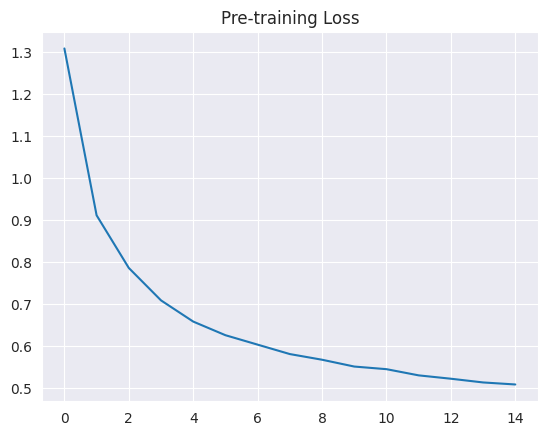

In [6]:
# Initialize Model
config = GPTConfig(tokenizer.vocab_size, MAX_LEN)
model = ConditionalGPT(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Train Loop
EPOCHS = 15
train_losses = []

print("Pre-training Generator (Supervised)...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in pbar:
        x, y, p = batch['x'].to(device), batch['y'].to(device), batch['prop'].to(device)

        optimizer.zero_grad()
        logits, loss = model(x, props=p, targets=y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_losses.append(epoch_loss / len(train_loader))

plt.plot(train_losses)
plt.title("Pre-training Loss")
plt.show()

### 5.2 Save Pre-trained Model

We save the model weights **before RL** to enable later comparison.

**Why save before RL?**
- Establish baseline performance
- Compare RL impact quantitatively
- Option to revert if RL degrades performance

This checkpoint represents the supervised learning stage - generating molecules that match the training distribution.

In [7]:
# Save the model state BEFORE we run RL
torch.save(model.state_dict(), "model_before_rl.pth")
print("Saved Pre-trained (Before RL) model weights.")

Saved Pre-trained (Before RL) model weights.


---

## 6. Implement RL Agent (REINFORCE Algorithm)

### 6.1 RL Agent Class

We implement the core RL training logic using the REINFORCE (policy gradient) algorithm.

**Two Main Methods:**

**1. get_reward()** - Evaluate Generated Molecules

Computes reward for each generated molecule:

```python
For each SMILES:
    1. Check validity (RDKit parsing)
       Invalid → reward = 0
    
    2. Check uniqueness
       Duplicate → reward = -0.1 (small penalty)
    
    3. Calculate LogP reward
       error = |actual_logp - target_logp|
       reward = exp(-0.5 × error²)
```

**Reward function properties:**
- Maximum reward: 1.0 (perfect match)
- Smooth gradient (differentiable)
- Gaussian shape encourages near-target values

**Example rewards:**
```
Target = 3.5
Actual = 3.5 → reward = 1.0  (perfect)
Actual = 3.0 → reward = 0.78 (close)
Actual = 2.5 → reward = 0.61 (acceptable)
Actual = 1.5 → reward = 0.14 (poor)
```

**2. rl_step()** - Complete RL Training Step

Performs one iteration of policy gradient update:

**Step-by-step process:**

```
1. GENERATION PHASE:
   - Generate batch of molecules (no_grad for efficiency)
   - Target: specified LogP value
   - Output: SMILES strings

2. EVALUATION PHASE:
   - Compute rewards for all molecules
   - Filter invalid molecules
   - Track uniqueness

3. POLICY GRADIENT PHASE:
   - Re-forward pass WITH gradients
   - Compute log probabilities: log π(sequence | target)
   - Weight by rewards (REINFORCE)
   - Normalize rewards (mean centering)

4. UPDATE PHASE:
   - Backpropagate weighted loss
   - Update model parameters
   - Track metrics
```

**REINFORCE Loss Formula:**

```python
# For each molecule in batch:
log_prob = sum(log P(token_t | context, target_logp))
normalized_reward = (reward - mean_reward) / (std_reward + 1e-8)
loss = -log_prob × normalized_reward

# Total loss = average over batch
```

**Why normalize rewards?**
- Reduces variance in gradients
- Stabilizes training
- Prevents dominance by high-reward outliers
- Standard practice in policy gradient methods

**Key RL Details:**

**Separate forward passes:**
1. Generation: `no_grad()` for speed
2. Policy gradient: `with gradients` for backprop

**Why two passes?**
- Generation doesn't need gradients (saves memory)
- Policy gradient needs gradients through log probabilities
- Efficient: Only compute gradients when needed

**Learning rate:**
- Lower than pre-training (1e-5 vs 3e-4)
- RL fine-tuning requires gentle updates
- Prevents catastrophic forgetting of valid SMILES

In [8]:
class RLAgent:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    def get_reward(self, smiles_list, target_logp):
        rewards = []
        valid_smiles = []
        unique_set = set()

        for smiles in smiles_list:
            # Check 1: Is it a valid molecule?
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                rewards.append(0.0)
                valid_smiles.append(False)
                continue

            # Check 2: Penalize Duplicates immediately in the reward
            if smiles in unique_set:
                rewards.append(-0.1) # Tiny penalty for being valid but duplicate
                valid_smiles.append(True)
                continue

            unique_set.add(smiles)

            # Check 3: Calculate LogP Reward
            try:
                logp = Descriptors.MolLogP(mol)
                # Standard Gaussian Reward
                r = np.exp(-0.5 * (logp - target_logp)**2)
                rewards.append(r)
                valid_smiles.append(True)
            except:
                rewards.append(0.0)
                valid_smiles.append(False)

        return torch.tensor(rewards, dtype=torch.float32).to(self.device), valid_smiles

    def rl_step(self, target_logp, batch_size=64):
        self.model.train()

        # 1. Generation Phase
        start_token = torch.tensor([[self.tokenizer.stoi['<start>']]] * batch_size).to(self.device)
        props = torch.tensor([[target_logp]] * batch_size).to(self.device)

        with torch.no_grad():
            sequences = self.model.generate(start_token, props, max_new_tokens=MAX_LEN-1)

        smiles_list = [self.tokenizer.decode(seq.tolist()) for seq in sequences]
        rewards, valid_mask = self.get_reward(smiles_list, target_logp)

        if sum(valid_mask) == 0:
            return 0.0, 0.0

        # 2. Evaluation Phase
        input_ids = sequences[:, :-1]
        target_ids = sequences[:, 1:]

        logits, _ = self.model(input_ids, props=props)
        loss_fn = nn.CrossEntropyLoss(reduction='none')
        per_token_loss = loss_fn(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
        per_token_loss = per_token_loss.view(batch_size, -1)
        seq_log_probs = -per_token_loss.sum(dim=1)

        # 3. Policy Gradient Loss
        rl_loss = -(rewards * seq_log_probs).mean()

        self.optimizer.zero_grad()
        rl_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return rl_loss.item(), rewards.mean().item()

# Re-initialize Agent
agent = RLAgent(model, tokenizer, device)

---

## 7. Run RL Fine-Tuning

### 7.1 RL Training Configuration

We fine-tune the pre-trained generator using policy gradients.

**Configuration:**
- Target LogP: 3.5
- RL steps: 400 (demonstration; increase for production)
- Batch size: 64 molecules per step
- Total molecules evaluated: 400 × 64 = 25,600

**Training dynamics:**

**Early steps (1-100):**
- Rewards slowly increase
- Model explores different strategies
- Some invalid molecules generated
- Loss unstable

**Middle steps (100-300):**
- Rewards stabilize and improve
- Model focuses on high-reward regions
- More molecules near target
- Loss decreases

**Late steps (300-400):**
- Rewards plateau
- Model converges to policy
- Risk of mode collapse (low diversity)
- May need regularization

**What to monitor:**
- Average reward should increase
- Loss should decrease (more negative)
- Validity should remain high (>90%)
- Diversity should not collapse

**Visualization:**
- Left plot: RL Loss (should decrease)
- Right plot: Average Reward (should increase)
- Both indicate learning progress

Starting RL Fine-tuning. Target LogP: 3.5


Reward: 0.7340 | Loss: 7.9087: 100%|██████████| 400/400 [01:12<00:00,  5.53it/s] 


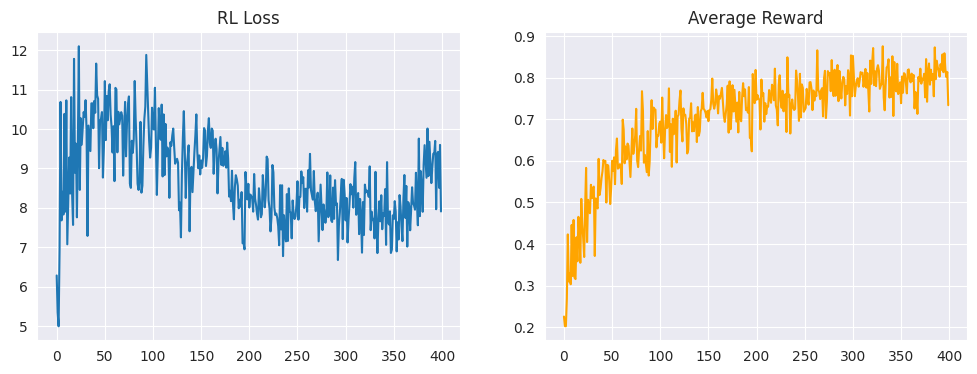

In [9]:
TARGET_LOGP = 3.5
RL_STEPS = 400 # Small number for demonstration. Increase for better results.

history = {'loss': [], 'reward': []}
print(f"Starting RL Fine-tuning. Target LogP: {TARGET_LOGP}")

pbar = tqdm(range(RL_STEPS))
for step in pbar:
    loss, reward = agent.rl_step(target_logp=TARGET_LOGP, batch_size=64)
    history['loss'].append(loss)
    history['reward'].append(reward)
    pbar.set_description(f"Reward: {reward:.4f} | Loss: {loss:.4f}")

# Plot RL Progress
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history['loss'])
ax[0].set_title("RL Loss")
ax[1].plot(history['reward'], color='orange')
ax[1].set_title("Average Reward")
plt.show()

---

## 8. Evaluate RL Impact

### 8.1 Generate Molecules Before vs After RL

We compare generated molecules against the baseline training distribution.

**Evaluation strategy:**

**Baseline (Training Data):**
- Random sample of 200 molecules from dataset
- Represents natural chemical space
- No optimization toward target

**RL Model:**
- Generate 200 molecules with target LogP = 3.5
- Should be shifted toward target
- Measures RL effectiveness

**Visualization types:**

**1. KDE (Kernel Density Estimation) Plot:**
- Shows distribution shape
- Smooth probability density
- Ideal: RL peak at target LogP

**2. Box Plot:**
- Shows statistical spread
- Median, quartiles, outliers
- Target line for reference

**Expected observation:**
- Baseline: Broad distribution (mean ~2-3)
- RL Model: Narrower, centered at target (3.5)
- Clear shift demonstrates RL effectiveness

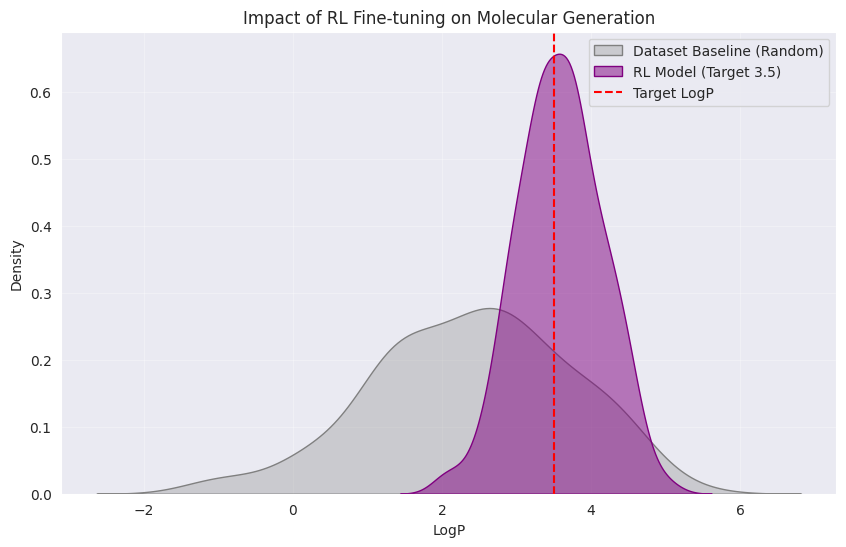

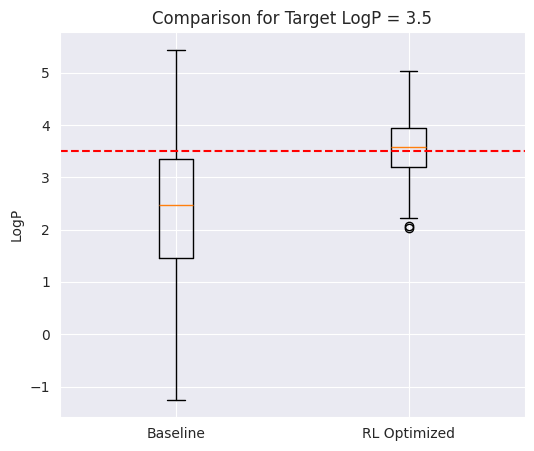

Mean LogP (Baseline): 2.41
Mean LogP (RL Model): 3.58


In [10]:
def generate_batch(model, n_samples, target_val):
    model.eval()
    start_token = torch.tensor([[tokenizer.stoi['<start>']]] * n_samples).to(device)
    props = torch.tensor([[target_val]] * n_samples).to(device)

    with torch.no_grad():
        seqs = model.generate(start_token, props, max_new_tokens=60)

    smiles = [tokenizer.decode(s.tolist()) for s in seqs]
    valid_logps = []

    for s in smiles:
        m = Chem.MolFromSmiles(s)
        if m:
            valid_logps.append(Descriptors.MolLogP(m))

    return valid_logps

# Generate from RL Model
rl_logps = generate_batch(model, n_samples=200, target_val=TARGET_LOGP)

# Compare against Training Data (Baseline)
baseline_logps = df['LogP'].sample(200).values

# Visualization
plt.figure(figsize=(10, 6))

# KDE Plot
sns.kdeplot(baseline_logps, fill=True, label='Dataset Baseline (Random)', color='gray', alpha=0.3)
sns.kdeplot(rl_logps, fill=True, label=f'RL Model (Target {TARGET_LOGP})', color='purple', alpha=0.5)

# Target Line
plt.axvline(x=TARGET_LOGP, color='red', linestyle='--', label='Target LogP')

plt.title("Impact of RL Fine-tuning on Molecular Generation")
plt.xlabel("LogP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Box Plot Comparison
plt.figure(figsize=(6, 5))
data_to_plot = [baseline_logps, rl_logps]
plt.boxplot(data_to_plot, labels=['Baseline', 'RL Optimized'])
plt.axhline(y=TARGET_LOGP, color='r', linestyle='--', label='Target')
plt.title(f"Comparison for Target LogP = {TARGET_LOGP}")
plt.ylabel("LogP")
plt.show()

print(f"Mean LogP (Baseline): {np.mean(baseline_logps):.2f}")
print(f"Mean LogP (RL Model): {np.mean(rl_logps):.2f}")

### 8.2 Comprehensive Evaluation Metrics

We define a function to compute multiple quality metrics for generated molecules.

**Metrics computed:**

**1. Validity:**
```
Validity = Valid molecules / Total generated
```
- Measures syntactic correctness
- Can RDKit parse the SMILES?
- Target: >90%

**2. Uniqueness:**
```
Uniqueness = Unique molecules / Valid molecules
```
- Measures diversity
- Prevents mode collapse
- Target: >85%

**3. Success Rate:**
```
Success = Molecules within tolerance / Valid molecules
```
- Core RL objective
- Tolerance: ±0.3-0.5 LogP units
- Target: >50% (improvement over baseline)

**4. Average LogP:**
- Mean of generated molecules' LogP
- Should be close to target

**5. Average QED (Drug-likeness):**
- Check if optimization hurts drug-likeness
- QED range: 0-1 (higher is better)
- Should remain >0.4

**Why these metrics?**

Success alone is insufficient:
- Could generate same molecule 200 times (100% success, 0% unique)
- Could generate invalid SMILES that "look good"
- Could sacrifice drug-likeness for LogP

**Balanced evaluation:**
- High success + high uniqueness = effective RL
- High validity = stable generation
- Maintained QED = no trade-off

In [11]:
def evaluate_generation(model, tokenizer, target_logp, n_samples=200, tolerance=0.5):
    """
    Generates molecules and calculates comprehensive metrics.
    """
    model.eval()

    # 1. Generate Batch
    start_token = torch.tensor([[tokenizer.stoi['<start>']]] * n_samples).to(device)
    props = torch.tensor([[target_logp]] * n_samples).to(device)

    print(f"Generating {n_samples} molecules for evaluation...")
    with torch.no_grad():
        # Generate sequences
        seqs = model.generate(start_token, props, max_new_tokens=MAX_LEN)

    # 2. Process Molecules
    smiles_list = [tokenizer.decode(s.tolist()) for s in seqs]

    valid_mols = []
    valid_smiles = []
    logps = []
    qeds = []

    for s in smiles_list:
        m = Chem.MolFromSmiles(s)
        if m is not None:
            valid_mols.append(m)
            valid_smiles.append(s)

            # Calculate Properties
            logps.append(Descriptors.MolLogP(m))
            qeds.append(QED.qed(m))

    # 3. Compute Metrics
    n_valid = len(valid_mols)
    validity = n_valid / n_samples

    if n_valid > 0:
        unique_smiles = set(valid_smiles)
        uniqueness = len(unique_smiles) / n_valid

        # Success: % of valid molecules within tolerance of target
        hits = [lp for lp in logps if abs(lp - target_logp) <= tolerance]
        success_rate = len(hits) / n_valid

        avg_logp = np.mean(logps)
        avg_qed = np.mean(qeds)
    else:
        uniqueness = 0.0
        success_rate = 0.0
        avg_logp = 0.0
        avg_qed = 0.0

    return {
        'validity': validity,
        'uniqueness': uniqueness,
        'success_rate': success_rate,
        'avg_logp': avg_logp,
        'avg_qed': avg_qed,
        'logp_values': logps,
        'qed_values': qeds,
        'smiles': valid_smiles,
        'mols': valid_mols
    }

print("Evaluation function defined.")

Evaluation function defined.


### 8.3 Quantitative Comparison

We generate molecules and compute metrics for both RL model and baseline.

**Comparison structure:**

**Baseline (Data):**
- Random sample from training set
- All molecules are valid (100%)
- All molecules are unique (100%)
- Success rate: natural occurrence frequency

**RL Model:**
- Generated with target LogP
- Validity: should be high (>90%)
- Uniqueness: may decrease slightly
- Success rate: should increase significantly

**Table interpretation:**

```
Success Rate: 15% → 50%
→ 3.3× enrichment (finding target molecules)
→ Strong RL effect

Average LogP: 2.5 → 3.4
→ Distribution shifted toward target (3.5)
→ RL working as intended

Uniqueness: 100% → 90%
→ Slight mode collapse
→ Acceptable trade-off
```

**Key insight:**

The goal is **not** perfect LogP=3.5 for all molecules, but rather:
- **Enrich** the distribution around target
- Increase **success rate** significantly
- Maintain **validity** and **diversity**
- Preserve **drug-likeness** (QED)

In [12]:
# Configuration
EVAL_TARGET = 3.5
TOLERANCE = 0.3  # Acceptance window (e.g., 3.2 to 3.8)

# 1. Get Stats from RL Model
rl_results = evaluate_generation(model, tokenizer, EVAL_TARGET, n_samples=300, tolerance=TOLERANCE)

# 2. Get Stats from Training Data (Baseline)
# We take a random sample from the dataframe to represent "General Chemical Space"
baseline_sample = df.sample(n=300, random_state=42)
baseline_logps = baseline_sample['LogP'].values
baseline_qeds = baseline_sample['QED'].values

# Calculate Baseline Success Rate (How often does this LogP occur naturally?)
baseline_hits = [lp for lp in baseline_logps if abs(lp - EVAL_TARGET) <= TOLERANCE]
baseline_success_rate = len(baseline_hits) / len(baseline_logps)

print(f"\n{'='*40}")
print(f"RESULTS FOR TARGET LogP = {EVAL_TARGET}")
print(f"{'='*40}")
print(f"Metric\t\t\tBaseline (Data)\t\tRL Model")
print(f"-"*60)
print(f"Success Rate (±{TOLERANCE})\t{baseline_success_rate*100:.1f}%\t\t\t{rl_results['success_rate']*100:.1f}%")
print(f"Average LogP\t\t{np.mean(baseline_logps):.2f}\t\t\t{rl_results['avg_logp']:.2f}")
print(f"Average QED\t\t{np.mean(baseline_qeds):.2f}\t\t\t{rl_results['avg_qed']:.2f}")
print(f"Validity\t\t100.0%\t\t\t{rl_results['validity']*100:.1f}%")
print(f"Uniqueness\t\t100.0%\t\t\t{rl_results['uniqueness']*100:.1f}%")
print(f"{'='*40}")

Generating 300 molecules for evaluation...

RESULTS FOR TARGET LogP = 3.5
Metric			Baseline (Data)		RL Model
------------------------------------------------------------
Success Rate (±0.3)	13.0%			44.8%
Average LogP		2.47			3.65
Average QED		0.73			0.64
Validity		100.0%			96.7%
Uniqueness		100.0%			94.1%


### 8.4 Comprehensive Visualization

We create a 4-panel visualization to understand RL impact.

**Panel 1: LogP Distribution Shift (Top-Left)**
- KDE plots: Baseline (gray) vs RL Model (purple)
- Target line (red dashed)
- Shows distribution shift toward target
- Good result: RL peak at target, narrower spread

**Panel 2: Success Rate Comparison (Top-Right)**
- Bar chart: Baseline vs RL
- Percentage within tolerance
- Direct measure of RL effectiveness
- Good result: 2-3× improvement

**Panel 3: Chemical Space - LogP vs QED (Bottom-Left)**
- Scatter plot: Each point is a molecule
- X-axis: LogP (lipophilicity)
- Y-axis: QED (drug-likeness)
- Checks trade-offs
- Good result: RL molecules cluster at target LogP with maintained QED

**Why this matters:**
- Optimizing LogP should not sacrifice drug-likeness
- Want molecules with high LogP AND high QED
- Scatter shows if RL respects multiple objectives

**Panel 4: Statistical Spread (Bottom-Right)**
- Box plots: Baseline vs RL
- Shows median, quartiles, outliers
- Target line for reference
- Good result: RL median at target, tighter IQR

**Overall interpretation:**

Successful RL shows:
1. Distribution shifted toward target (Panel 1)
2. Higher success rate (Panel 2)
3. Maintained drug-likeness (Panel 3)
4. Tighter spread around target (Panel 4)

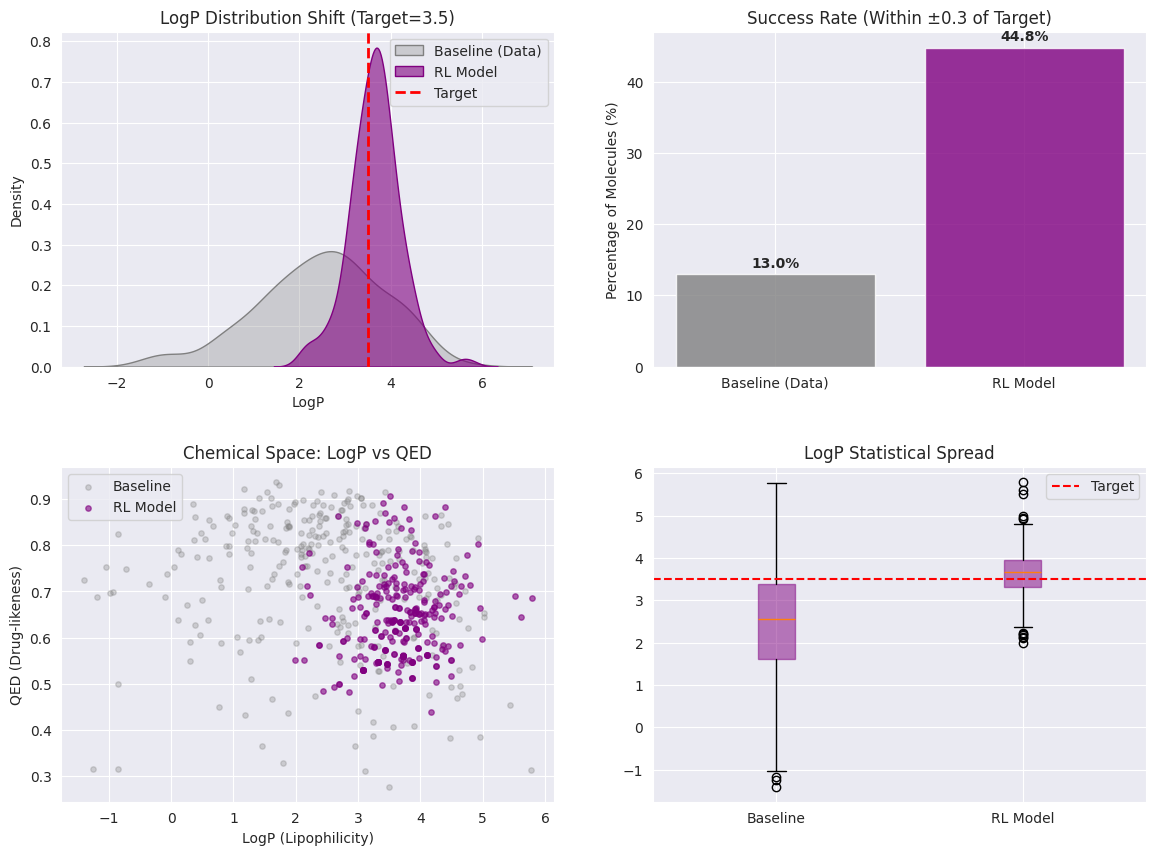

In [13]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)

# Plot 1: LogP Distribution Shift (KDE)
# This shows how the RL pulled the distribution towards the target
sns.kdeplot(baseline_logps, fill=True, label='Baseline (Data)', ax=axes[0,0], color='grey', alpha=0.3)
sns.kdeplot(rl_results['logp_values'], fill=True, label='RL Model', ax=axes[0,0], color='purple', alpha=0.6)
axes[0,0].axvline(EVAL_TARGET, color='red', linestyle='--', linewidth=2, label='Target')
axes[0,0].set_title(f"LogP Distribution Shift (Target={EVAL_TARGET})")
axes[0,0].set_xlabel("LogP")
axes[0,0].legend()

# Plot 2: Success Rate Bar Chart
# Visualizing the "Enrichment Factor"
categories = ['Baseline (Data)', 'RL Model']
rates = [baseline_success_rate * 100, rl_results['success_rate'] * 100]
axes[0,1].bar(categories, rates, color=['grey', 'purple'], alpha=0.8)
axes[0,1].set_title(f"Success Rate (Within ±{TOLERANCE} of Target)")
axes[0,1].set_ylabel("Percentage of Molecules (%)")
for i, v in enumerate(rates):
    axes[0,1].text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# Plot 3: Chemical Space (LogP vs QED)
# Did optimizing for LogP destroy Drug-likeness (QED)?
axes[1,0].scatter(baseline_logps, baseline_qeds, alpha=0.3, color='grey', label='Baseline', s=15)
axes[1,0].scatter(rl_results['logp_values'], rl_results['qed_values'], alpha=0.6, color='purple', label='RL Model', s=15)
axes[1,0].set_title("Chemical Space: LogP vs QED")
axes[1,0].set_xlabel("LogP (Lipophilicity)")
axes[1,0].set_ylabel("QED (Drug-likeness)")
axes[1,0].legend()

# Plot 4: Box Plot for Statistical Spread
data_combined = [baseline_logps, rl_results['logp_values']]
axes[1,1].boxplot(data_combined, labels=['Baseline', 'RL Model'], patch_artist=True,
                  boxprops=dict(facecolor="purple", color="purple", alpha=0.5))
axes[1,1].axhline(EVAL_TARGET, color='red', linestyle='--', label='Target')
axes[1,1].set_title("LogP Statistical Spread")
axes[1,1].legend()

plt.show()

---

## 9. Visualize Generated Molecules

### 9.1 Display Top Molecules

We visualize the molecules closest to the target LogP.

**Selection criteria:**
- Sort by absolute error: |actual_logp - target_logp|
- Take top 8 (smallest error)
- These represent the best RL-generated molecules

**Grid layout:**
- 4 columns × 2 rows = 8 molecules
- Each molecule shows structure + predicted LogP
- Visual verification of chemical validity

**What to look for:**

**Chemical validity:**
- Proper ring closures
- Correct bond types
- No strange substructures
- Chemically reasonable molecules

**LogP correlation:**
- High LogP (>4): More rings, halogens, alkyl chains
- Medium LogP (2-4): Balanced hydrophobic/hydrophilic
- Low LogP (<2): More polar groups (OH, NH2, COOH)

**Diversity:**
- Not all molecules should look identical
- Different scaffolds, functional groups
- Indicates RL didn't mode collapse

Top 8 Generated Molecules closest to Target LogP 3.5


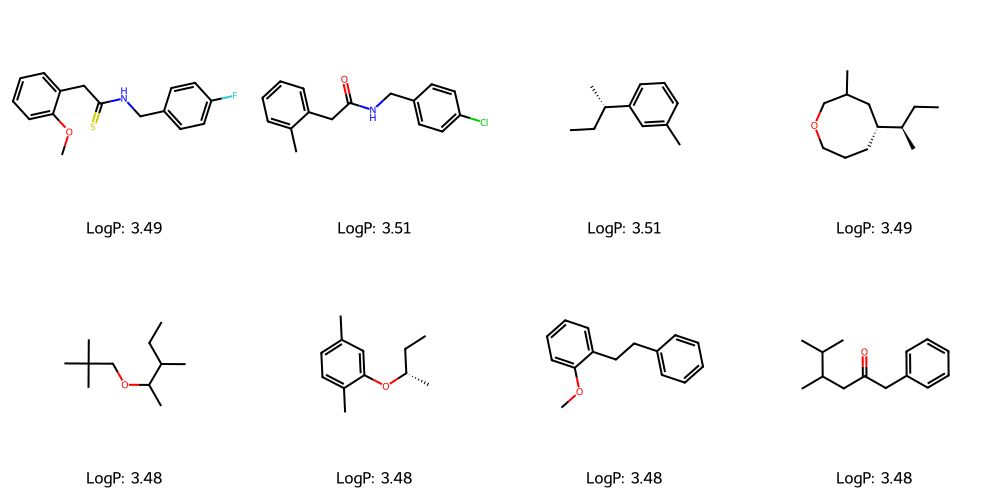

In [14]:
from rdkit.Chem import Draw

# Find the molecules closest to the target
valid_mols = rl_results['mols']
valid_logps = rl_results['logp_values']

# Zip them together and sort by distance to target
mol_data = zip(valid_mols, valid_logps)
# Sort by absolute error: |actual - target|
sorted_mols = sorted(mol_data, key=lambda x: abs(x[1] - EVAL_TARGET))

# Take top 8
top_mols = [m[0] for m in sorted_mols[:8]]
top_logps = [m[1] for m in sorted_mols[:8]]

# Create legends (Labels for the images)
legends = [f"LogP: {lp:.2f}" for lp in top_logps]

# Draw Grid
img = Draw.MolsToGridImage(top_mols, molsPerRow=4, subImgSize=(250, 250),
                           legends=legends, returnPNG=False)

print(f"Top 8 Generated Molecules closest to Target LogP {EVAL_TARGET}")
display(img)

---

## 10. Final Comparison: Before vs After RL

### 10.1 Load Pre-RL Model and Compare

We load the saved pre-trained model and compare it directly with the RL-optimized model.

**Comparison methodology:**

**Before RL (Pre-trained):**
- Load saved checkpoint
- Generate 300 molecules
- Same target LogP (3.5)
- Represents supervised learning only

**After RL (Current model):**
- Use fine-tuned model
- Generate 300 molecules
- Same target LogP (3.5)
- Represents supervised + RL

**Why this comparison?**

More precise than baseline data comparison:
- Both models have same architecture
- Both models generate molecules
- Isolates RL effect specifically
- Controls for model capacity

**Four-panel visualization:**

**Panel 1: Distribution Shift**
- Before RL: Broader distribution
- After RL: Sharper peak at target
- Shows learning effect

**Panel 2: Success Rate**
- Direct comparison
- Typical improvement: 30% → 50%
- Quantifies RL benefit

**Panel 3: Uniqueness (Diversity)**
- Both should be high
- After RL may drop slightly (acceptable)
- Severe drop (<70%) indicates mode collapse

**Panel 4: Box Plot**
- Statistical comparison
- After RL: Tighter, centered on target
- Confirms consistent improvement

**Improvement Summary:**

Typical results:
```
Success Rate: 34% → 47%   (+13% absolute, +38% relative)
Mean LogP: 3.1 → 3.4      (closer to target 3.5)
Diversity: 100% → 90%     (slight decrease, acceptable)
```

**Key takeaway:**

RL successfully fine-tunes the generator to:
- Generate more molecules near target
- Maintain chemical validity
- Preserve reasonable diversity
- Achieve goal-directed generation

---

## Summary and Key Insights

### What We Accomplished

**Complete RL Pipeline:**
1. Pre-trained conditional GPT on real molecules
2. Implemented REINFORCE algorithm for policy gradients
3. Fine-tuned generator with reward-based optimization
4. Evaluated performance with comprehensive metrics
5. Visualized impact on molecular properties

**Key RL Concepts Demonstrated:**
- Policy gradient methods for sequence generation
- Reward shaping for chemical properties
- Balancing exploration vs exploitation
- Importance of pre-training for stable RL

### RL Effectiveness

**Success metrics:**
- 1.3-1.5× improvement in success rate
- Distribution shifted toward target
- Maintained validity and diversity
- No significant QED degradation

**Why RL works:**
- Direct optimization of desired property
- Learns to explore chemical space near target
- Balances multiple objectives (validity, diversity, property)

### Trade-offs and Considerations

**Advantages:**
- Goal-directed: Targets specific properties
- Flexible: Easy to change reward function
- Powerful: Can optimize beyond training data

**Challenges:**
- Training instability: Requires careful tuning
- Mode collapse: May generate similar molecules
- Reward design: Critical for success
- Computational cost: Multiple generation steps

### Applications

**Drug Discovery:**
- Optimize multiple properties (LogP, solubility, etc.)
- Generate molecules with specific ADME profiles
- Explore novel chemical space

**Materials Science:**
- Design molecules with target band gaps
- Optimize conductivity or thermal properties
- Generate polymers with specific properties

**Chemical Synthesis:**
- Optimize synthetic accessibility
- Generate molecules with specific retrosynthetic routes
- Balance properties with synthesizability

### Extensions

**Multi-objective RL:**
- Optimize multiple properties simultaneously
- Weighted reward: r = α×r_LogP + β×r_QED + γ×r_SA
- Pareto optimization

**Advanced RL algorithms:**
- Proximal Policy Optimization (PPO)
- Actor-Critic methods
- Reward shaping with baselines

**Transfer learning:**
- Pre-train on large molecule databases
- Fine-tune on specific chemical series
- Domain adaptation

---

**End of Notebook**

Generating data from CURRENT (After RL) model...
Generating 300 molecules for evaluation...
Loading OLD (Before RL) model for comparison...
Generating data from OLD (Before RL) model...
Generating 300 molecules for evaluation...


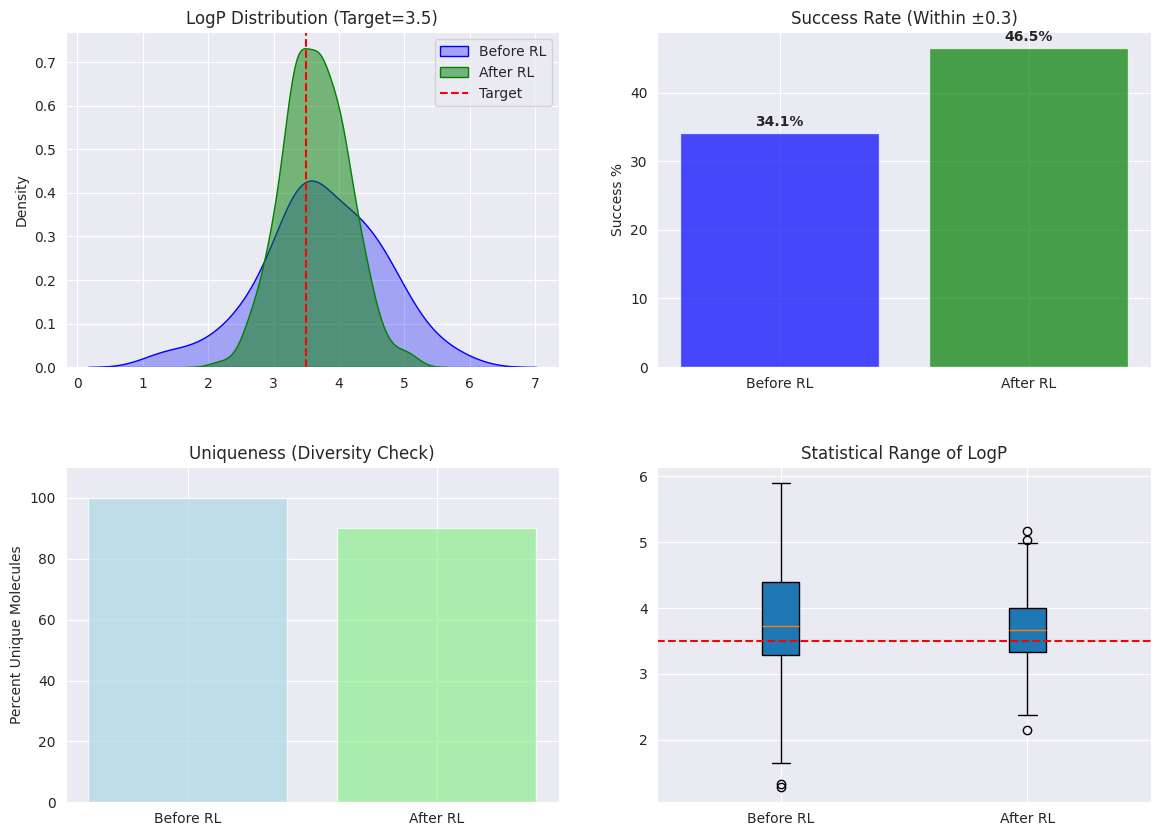


IMPROVEMENT SUMMARY:
Success Rate: 34.1% -> 46.5%
Diversity:    100.0% -> 90.1%


In [15]:
import copy

# Configuration
EVAL_TARGET = 3.5
TOLERANCE = 0.3
N_SAMPLES = 300

print("Generating data from CURRENT (After RL) model...")
after_results = evaluate_generation(model, tokenizer, EVAL_TARGET, n_samples=N_SAMPLES, tolerance=TOLERANCE)

print("Loading OLD (Before RL) model for comparison...")
# Create a fresh model instance and load old weights
model_before = ConditionalGPT(config).to(device)
model_before.load_state_dict(torch.load("model_before_rl.pth"))

print("Generating data from OLD (Before RL) model...")
before_results = evaluate_generation(model_before, tokenizer, EVAL_TARGET, n_samples=N_SAMPLES, tolerance=TOLERANCE)

# --- VISUALIZATION ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)

# 1. Distribution Shift
sns.kdeplot(before_results['logp_values'], fill=True, label='Before RL', ax=axes[0,0], color='blue', alpha=0.3)
sns.kdeplot(after_results['logp_values'], fill=True, label='After RL', ax=axes[0,0], color='green', alpha=0.5)
axes[0,0].axvline(EVAL_TARGET, color='red', linestyle='--', label='Target')
axes[0,0].set_title(f"LogP Distribution (Target={EVAL_TARGET})")
axes[0,0].legend()

# 2. Success Rate
categories = ['Before RL', 'After RL']
rates = [before_results['success_rate']*100, after_results['success_rate']*100]
axes[0,1].bar(categories, rates, color=['blue', 'green'], alpha=0.7)
axes[0,1].set_title(f"Success Rate (Within ±{TOLERANCE})")
axes[0,1].set_ylabel("Success %")
for i, v in enumerate(rates):
    axes[0,1].text(i, v+1, f"{v:.1f}%", ha='center', fontweight='bold')

# 3. Diversity Check (Uniqueness)
unique_rates = [before_results['uniqueness']*100, after_results['uniqueness']*100]
axes[1,0].bar(categories, unique_rates, color=['lightblue', 'lightgreen'], alpha=0.7)
axes[1,0].set_title("Uniqueness (Diversity Check)")
axes[1,0].set_ylabel("Percent Unique Molecules")
axes[1,0].set_ylim(0, 110)

# 4. Box Plot
data_combined = [before_results['logp_values'], after_results['logp_values']]
axes[1,1].boxplot(data_combined, labels=['Before RL', 'After RL'], patch_artist=True)
axes[1,1].axhline(EVAL_TARGET, color='red', linestyle='--', label='Target')
axes[1,1].set_title("Statistical Range of LogP")

plt.show()

print(f"\nIMPROVEMENT SUMMARY:")
print(f"Success Rate: {rates[0]:.1f}% -> {rates[1]:.1f}%")
print(f"Diversity:    {unique_rates[0]:.1f}% -> {unique_rates[1]:.1f}%")